# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

import matplotlib.pyplot as plt

from lightgbm import LGBMRanker
from catboost import CatBoostClassifier

In [106]:
data = pd.read_csv('data/retail_train.csv')
item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [5]:
recommender = MainRecommender(data_train_lvl_1)

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [31]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [36]:
result_lvl_1['test_k'] = result_lvl_1['user_id'].apply(
        lambda x: recommender.get_als_recommendations(x, 500))

In [37]:
results = {}
for n in (20, 50, 100, 200, 500):
    results[n] = result_lvl_1.apply(lambda x: recall_at_k(x['test_k'], x['actual'], n), axis=1).mean()

In [30]:
np.isin([1, 2, 9], [1, 8])

array([ True, False, False])

In [38]:
results

{20: 0.029903299556761104,
 50: 0.04798507255845161,
 100: 0.07012775973221028,
 200: 0.09793590385501039,
 500: 0.14716375030813977}

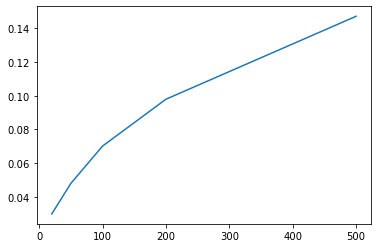

In [53]:
plt.plot(results.keys(), results.values())

### Видно, что recall@k быстро растет при росте k, при переходе от 20 к 500 возрастает в 7 раз, попробую формировать 100 кандидатов, после чего ранжировать их

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [109]:
data_train_lvl_2 = prefilter_items(data_train_lvl_2, 5000, item_features)

In [110]:
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique(), columns=['user_id'])
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

In [111]:
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, 100))

In [113]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

In [114]:
users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

,user_id,item_id,flag
0,2021,879504,1
0,2021,883932,1
0,2021,899624,1
0,2021,8090537,1


In [115]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1
targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, how='left', on=['user_id', 'item_id'])
targets_lvl_2.fillna(0, inplace=True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [119]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2021,879504,0.0,972,GROCERY,National,BAG SNACKS,POTATO CHIPS,12 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021,883932,1.0,586,GROCERY,National,CRACKERS/MISC BKD FD,SOUP CRACKERS (SALTINE/OYSTER),16 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021,899624,0.0,69,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021,8090537,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021,1106523,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
cat_features = targets_lvl_2.columns.to_list()[3:]

In [123]:
X = targets_lvl_2.drop('target', axis=1)
y = targets_lvl_2['target']

In [137]:
X.fillna('nan', inplace=True)

In [193]:
ranker = CatBoostClassifier(cat_features=cat_features, silent=True, learning_rate=1e-2)

In [194]:
ranker.fit(X, y)

In [195]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.rename(columns={'item_id': 'actual'}, inplace=True)

In [196]:
candidates = recommender.get_als_recommendations(1, 5)
df = pd.DataFrame([[u, i] for u, i in zip([1]*5, candidates)], columns=['user_id', 'item_id'])

In [197]:
def get_ranked_predictions(user_id, ranker=ranker, item_features=item_features, user_features=user_features, N=100):
    candidates = recommender.get_als_recommendations(user_id, N)
    df = pd.DataFrame([[u, i] for u, i in zip([user_id]*N, candidates)], columns=['user_id', 'item_id'])
    df = df.merge(item_features, on='item_id', how='left')
    df = df.merge(user_features, on='user_id', how='left')
    df.fillna('nan', inplace=True)
    df['proba'] = ranker.predict_proba(df)[:, 0]
    df.sort_values('proba', ascending=False, inplace=True)
    return df['item_id'].to_list()

In [198]:
result_lvl_2['ranked_recs'] = result_lvl_2['user_id'].apply(lambda x: get_ranked_predictions(x))

In [201]:
result_lvl_2.head()

,user_id,actual,ranked_recs
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[917393, 987734, 1087411, 1096261, 906611, 927..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[863885, 995876, 10149656, 919534, 1029685, 11..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1043301, 941361, 869177, 8203834, 1127732, 10..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[6533878, 1118547, 915715, 1115139, 1061228, 1..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[991024, 995226, 851528, 1052752, 1034838, 113..."


In [200]:
result_lvl_2.apply(lambda x: recall_at_k(x['ranked_recs'], x['actual'], 100), axis=1).mean()

0.0683265700350318

### Результат даже чуть снизился, думаю, нужно подобрать гиперпараметры